# Visual Search Report

## Introduction

The visual search experiment is a psychology experiment that is used to study how the human visual system processes and searches for specific stimuli in a visual scene. The experiment typically involves presenting participants with a visual display, such as a picture or a computer screen, that contains a number of objects or stimuli. The participants are then asked to search for a specific target stimulus, such as a pink line, among the other stimuli in the display.

During the experiment, the researcher may manipulate various factors, such as the number of stimuli in the display, the similarity of the stimuli to the target, or the location of the target within the display. These manipulations allow the researcher to study how different factors affect the speed and accuracy of the participant's search for the target stimulus.

One of the most widely used manipulation in visual search experiment is the set size, which is the number of stimuli in the display. The experimenter increases the set size and observe how it affects the reaction time of the participants. 

Another manipulation that is often used in visual search experiments is the similarity of the stimuli to the target. This can include manipulating the color, shape, or size of the stimuli to make them more or less similar to the target. The experimenter can observe how these manipulations affect the speed and accuracy of the participant's search for the target.

The visual search experiment is a powerful tool for studying the human visual system because it allows researchers to study how the brain processes and searches for specific stimuli in a visual scene. The results of these experiments have provided insight into how the visual system processes information, and have applications in fields such as cognitive psychology, neuroscience, and engineering.

Overall, visual search experiment is a widely used method in cognitive psychology to study how visual perception and attention work. It provides researchers with a tool to investigate fundamental question about how we perceive and process visual information in the world around us.

## Experiment Setup

We will study how the reaction time changes as set size increases under different circumstances. Specifically, the effects of set size, homogeneity (feature vs. conjunction) and target presence on reaction time will be examined. A total of N=3 participants will be recruited for the study. We then fit a linear regression model predicting the 
reaction time based on the set size, search type and target presence. We will be interested in the coefficient in the linear model corresponding to set size. This will be our measure of efficiency.

The experiment will consist of 300 trials, in which participants will be presented with an image containing a set of lines with different orientations (either ``/`` or ``\``). The participants will be instructed to search for a pink line with an orientation of ``/`` and indicate whether it is present or absent. The trials will vary in set size (10, 20, 30, or 40) and search type (feature or conjunction). In _feature search_, the image will contain only lines of a single color (lines with orientation ``\`` act as distractors), while in _conjunction search_, the image will contain a mixture of blue and pink lines (blue lines and pink lines with orientation ``\`` act as distractors). Participants will be provided with feedback on the accuracy of their responses and encouraged to respond as quickly as possible. The estimated duration of the experiment is approximately 15-20 minutes.

The participants consisted of students in age range 20-25 years old. Both genders were represented. The participants were seated in front of a 14-inch monitor with 1920x1080 resolution and instructed to make themselves comfortable. No training trials were conducted prior to the experiment. No participant needed to take a break during the experiment.

In [1]:
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# classes for special types
from pandas.api.types import CategoricalDtype

# Apply the default theme
sns.set_theme(style="ticks")

# Set default precision for displaying numbers
pd.set_option("display.precision", 2)

In [2]:
# Load data
data_path = Path('data/')


def load_file(filepath : Path) -> pd.DataFrame:
    participant_id = filepath.stem
    df = pd.read_csv(filepath)
    
    # Delete rows that do not contain response data
    df = df[df.trial_type == 'canvas-keyboard-response']
    
    df['participant'] = participant_id
    df = df.rename({"setSize": "set_size"}, axis=1)
    df = df[['participant', 'present', 'set_size', 'conjuction','correct' , 'rt']]
    df = df.astype({"participant": int, "present": bool, 'set_size': int, 'conjuction': bool, 'correct': bool, 'rt': int})
    df = df.reset_index(drop=True)
    
    return df


df_all = pd.concat(load_file(file) for file in data_path.glob("*.csv")).reset_index(drop=True)
df_all = df_all[df_all['participant'] > 0]

In [3]:
df_all.head()

,participant,present,set_size,conjuction,correct,rt
320,1,True,30,True,True,2975
321,1,True,20,True,True,713
322,1,False,20,True,True,1641
323,1,False,30,False,True,2071
324,1,False,10,True,True,1064


In [4]:
df_all.dtypes

participant    int64
present         bool
set_size       int64
conjuction      bool
correct         bool
rt             int64
dtype: object

In [5]:
# Remove incorrect responses
df_correct = df_all[df_all.correct]
df_correct

,participant,present,set_size,conjuction,correct,rt
320,1,True,30,True,True,2975
321,1,True,20,True,True,713
322,1,False,20,True,True,1641
323,1,False,30,False,True,2071
324,1,False,10,True,True,1064
...,...,...,...,...,...,...
1273,3,False,10,True,True,656
1274,3,False,20,False,True,655
1276,3,False,40,False,True,1585
1277,3,True,20,False,True,598


## Results

In [6]:
# Report accuracy
df_all.groupby('participant').agg(accuracy=('correct', 'mean')).round(decimals=3)

,accuracy
participant,
1,0.94
2,0.98
3,0.94


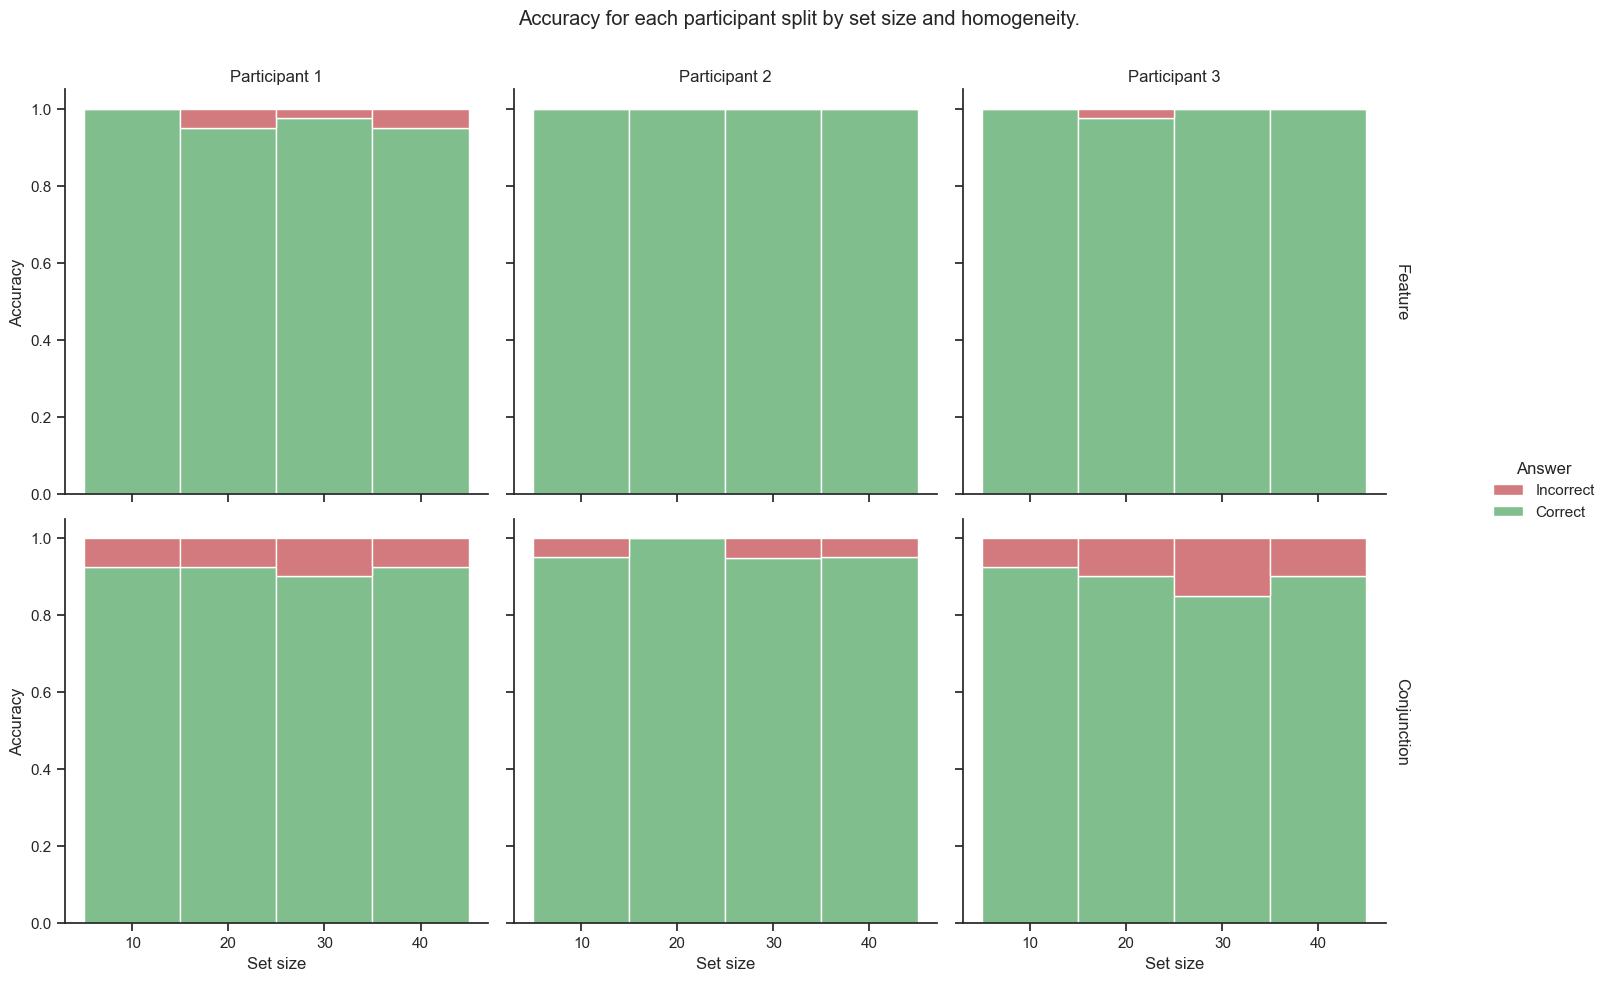

In [7]:
# Plot the accuracy of each participant split by set size and homogeneity

hlp = df_all.groupby(['participant','set_size', 'conjuction']).agg(Correct=('correct', 'mean'), Incorrect=('correct', lambda _: 1 - _.mean())).reset_index()
hlp = pd.melt(hlp, id_vars=['participant','set_size', 'conjuction'], var_name='is_correct', value_name='perc')
hlp['participant'] = hlp['participant'].astype(str)
hlp['set_size'] = hlp['set_size'].astype(str)
hlp['conjuction'] = hlp['conjuction'].map(lambda _: 'Conjunction' if _ else 'Feature')
hlp = hlp.sort_values(['participant', 'set_size'])

g = sns.displot(
    data=hlp,
    x='set_size',
    hue='is_correct',
    multiple='stack',
    col='participant',
    row='conjuction',
    weights='perc',
    palette={'Correct': 'g', 'Incorrect': 'r'},
    hue_order=['Incorrect', 'Correct'],
    facet_kws=dict(margin_titles=True),
)
g.set_titles(col_template="Participant {col_name}", row_template="{row_name}")
g.set_ylabels("Accuracy")
g.set_xlabels("Set size")
g.legend.set_title("Answer")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Accuracy for each participant split by set size and homogeneity.");

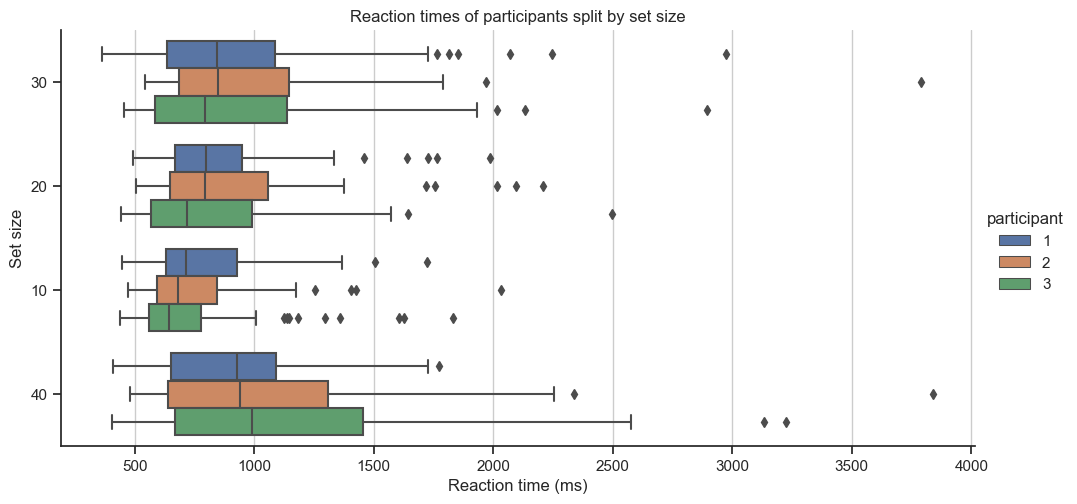

In [8]:
# Plot reaction times split by set size

hlp = df_correct[["participant", "set_size", "rt"]].copy()

# Treat set size as categorical data
hlp["set_size"] = hlp["set_size"].astype(str)

g = sns.catplot(data=hlp, y="set_size", x="rt", hue='participant', kind='box', aspect=2)
g.ax.xaxis.grid(True)
g.set_xlabels("Reaction time (ms)")
g.set_ylabels("Set size")
g.set(title="Reaction times of participants split by set size");

In [9]:
# Fit a linear regression model predicting the reaction time based on set size. Consider cases with different homogeneity
# and whether the target was present or not and report the slope of
# the coefficient for reaction time and 95% confidence interval. This time consider

participants = df_correct.participant.unique()
df_result = pd.DataFrame(columns=["participant", "conjunction", "present", "set_size_slope", "ci_l", "ci_u", "r2"])
for participant in participants:
    for is_conjunction in [True, False]:
        for target_present in [True, False]:
            hlp = df_correct[
                (df_correct.participant == participant) &
                (df_correct.conjuction == is_conjunction) &
                (df_correct.present == target_present)
            ]
            model = smf.ols('rt ~ set_size', data=hlp)
            result = model.fit()

            ci = result.conf_int(alpha=0.05).loc["set_size"]
            tmp = [
                participant,
                int(is_conjunction),
                int(target_present),
                result.params["set_size"],
                ci[0],
                ci[1],
                result.rsquared
            ]
            df_result = pd.concat([df_result, pd.DataFrame([tmp], columns=df_result.columns)], ignore_index=True)

df_result = df_result.assign(
    yerr=lambda _: np.abs(_['set_size_slope'] - _['ci_l']),
)

In [15]:
df_result.columns

Index(['participant', 'conjunction', 'present', 'set_size_slope', 'ci_l',
       'ci_u', 'r2', 'yerr'],
      dtype='object')

In [21]:
# Print pretty table
hlp = df_result[
    ['participant', 'conjunction', 'present', 'set_size_slope', 'ci_l','ci_u']
].copy()
hlp['conjunction'] = hlp['conjunction'].map(lambda _: 'Conjunction' if _ == 1 else 'Feature')
hlp['present'] = hlp['present'].map(lambda _: 'Y' if _ == 1 else 'F')
hlp = hlp.rename(
    {
        "participant": "Participant",
        "conjunction": "Homogeneity",
        "conjunction": "Target Present",
        "set_size_slope": "Search Slope",
        "ci_l": "95% CI Lower",
        "ci_u": "95% CI Upper",
    },
    axis='columns'
)
hlp

,Participant,Target Present,present,Search Slope,95% CI Lower,95% CI Upper
0,1,Conjunction,Y,8.20,0.13,16.27
1,1,Conjunction,F,9.14,2.22,16.07
2,1,Feature,Y,-2.18,-5.95,1.59
3,1,Feature,F,6.12,-0.05,12.29
4,2,Conjunction,Y,4.78,-1.24,10.79
5,2,Conjunction,F,24.34,17.54,31.14
6,2,Feature,Y,-1.59,-10.00,6.83
7,2,Feature,F,10.69,2.14,19.23
8,3,Conjunction,Y,17.91,9.77,26.06
9,3,Conjunction,F,17.77,7.89,27.66


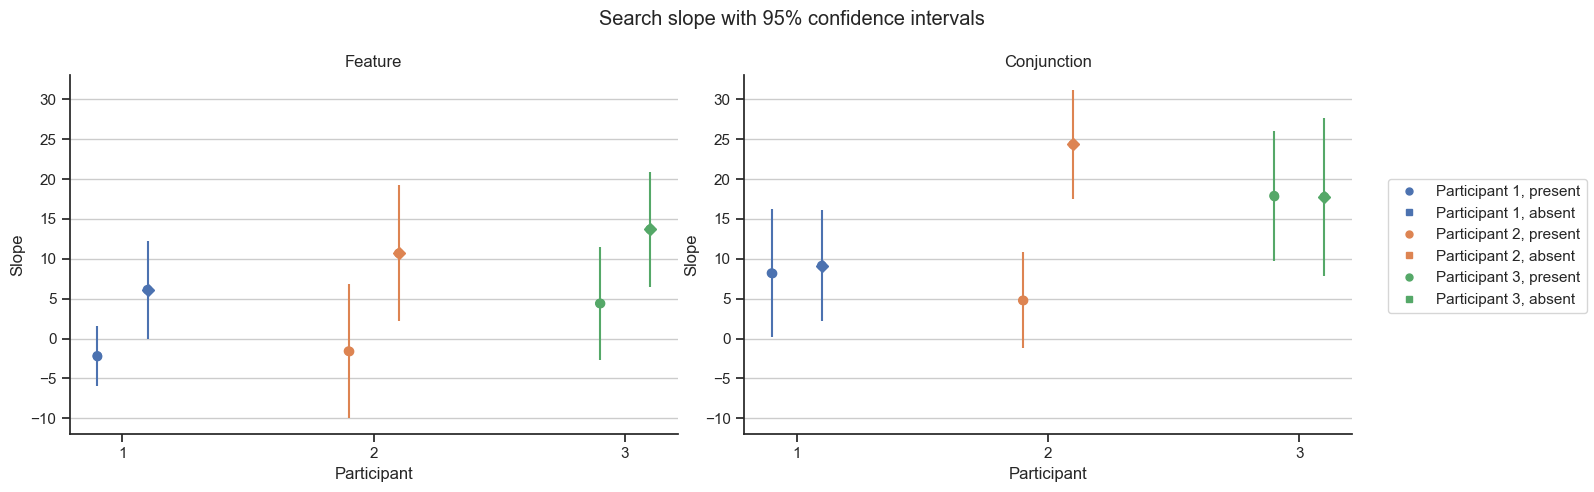

In [13]:
# Plot search slope for target present absent and feature or conjunction
from matplotlib.lines import Line2D

colors = ['C0', 'C1', 'C2']
markers = []
labels = []
for participant, color in enumerate(colors):
    for target_present, shape in [('present', 'o'), ('absent', 's')]:
        marker = Line2D(
            [], [], color=color, marker=shape, linestyle='none', markersize=5
        )
        markers.append(marker)
        labels.append('Participant ' + str(participant + 1) + ', ' + target_present)
    
    
min_y = np.floor(df_result.ci_l.min()) - 1
max_y = np.ceil(df_result.ci_u.max()) + 1

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

data = [
        ("Feature", df_result[df_result.conjunction == 0]),
        ("Conjunction", df_result[df_result.conjunction == 1])
]

delta = 0.1
for i, (title, df) in enumerate(data):
    for target_present in [True, False]:
        hlp = df[df.present == target_present]
        
        axes[i].scatter(
            hlp.participant + (-delta if target_present else delta),
            hlp.set_size_slope,
            color=colors,
        )

        for color, participant in zip(colors, hlp.participant):
            row = hlp[hlp.participant == participant]
            
            axes[i].errorbar(
                participant + (-delta if target_present else delta),
                row.set_size_slope,
                yerr=row.yerr,
                ls='none',
                marker='o' if target_present else 'D',
                ecolor=color,
                c=color,
            )

    # Hide the right and top spines
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].grid(which='major', axis='y', linestyle='-')
    axes[i].set_xticks(hlp.participant.astype(float))
    axes[i].set(title=title, xlabel='Participant', ylabel='Slope')
    axes[i].set_ylim(bottom=min_y, top=max_y)

    

fig.suptitle("Search slope with 95% confidence intervals")
fig.tight_layout()
fig.subplots_adjust(right=0.85)
fig.legend(
    markers,
    labels,
    loc=7,
);

# Conclusion